# Happy Hotel

## Problem:

Given reviews for ten hotels, design and execute a method to identify topics within the reviews. For each topic, 
find a robust means of assigning a score to each hotel in that topic. For each of the ten hotels, make 
recommendations to their general managers.

## Approch:

1). Use LDA topic modeling to get the topics of the reviews. 

2). Then get the main topics each review talked about. 

3). Use the percentage contribution of topics as the scores each reviewer gave to the topics. If it was a happy 
review, then it is a positive score, otherwise, it is a negative score. 

4). Then for each hotel, its score for a given topic is the sum of all the percentage contributions of all the 
reviews. 

5). Also get the top reviews for each topic for each hotel, so that the managers can have an idea what they did 
great and what they need improve.

## Results

1). Found 14 topics in the reviews.

2). Obtained the scores and top reviews for each topic for each hotel. 

3). For Hotel 1, it's close to a highway, and noisy, and thus some actions need to be taken to reduce the noise. Its billing department also need to improve their service. Its staffs were friendly and did a good job. Its location in NYC are close to many landmarks, and thus 
can be used in the advertisement to attract more customers. Suggestions for other hotels can be obtained similarly.

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser
from gensim.models.ldamodel import LdaModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# NLTK Stop words
import nltk; 
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /Users/ll/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Load Data

In [3]:
# Import Dataset for 'happy reviews'
df_happy = pd.read_excel('./Happy Hotel Data Set/hotel_happy_reviews.xlsx')
df_happy.head()

,User_ID,Description,Is_Response,hotel_ID
0,id10329,Stayed here with husband and sons on the way t...,happy,8
1,id10331,We had - rooms. One was very nice and clearly ...,happy,3
2,id10333,My wife & I stayed in this glorious city a whi...,happy,3
3,id10334,My boyfriend and I stayed at the Fairmont on a...,happy,7
4,id10336,"Steps off Times Square, nice rooms, stayed - n...",happy,3


In [4]:
df_happy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26521 entries, 0 to 26520
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   User_ID      26521 non-null  object
 1   Description  26521 non-null  object
 2   Is_Response  26521 non-null  object
 3   hotel_ID     26521 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 828.9+ KB


In [5]:
# Import Dataset for 'not happy reviews'
df_nothappy = pd.read_excel('./Happy Hotel Data Set/hotel_not_happy_reviews.xlsx')
df_nothappy.head()

,User_ID,Description,Is_Response,hotel_ID
0,id10326,The room was kind of clean but had a VERY stro...,not happy,3
1,id10327,I stayed at the Crown Plaza April -- - April -...,not happy,9
2,id10328,I booked this hotel through Hotwire at the low...,not happy,3
3,id10330,My girlfriends and I stayed here to celebrate ...,not happy,3
4,id10332,My husband and I have stayed in this hotel a f...,not happy,7


In [6]:
df_nothappy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12411 entries, 0 to 12410
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   User_ID      12411 non-null  object
 1   Description  12411 non-null  object
 2   Is_Response  12411 non-null  object
 3   hotel_ID     12411 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 388.0+ KB


In [7]:
# Combine the happy and not happy reviews
df = pd.concat([df_happy, df_nothappy], ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38932 entries, 0 to 38931
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   User_ID      38932 non-null  object
 1   Description  38932 non-null  object
 2   Is_Response  38932 non-null  object
 3   hotel_ID     38932 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [8]:
# Number of reviews for each hotel
df.hotel_ID.value_counts()

4     6847
5     6682
8     5353
7     5317
3     5082
1     3929
2     2058
10    1511
6     1157
9      996
Name: hotel_ID, dtype: int64

# 2. Data Preprocessing

In [9]:
# Remove space characters in 'Description'
sentences = [re.sub('\s+', ' ', s) for s in df.Description]

In [10]:
# Tokenize, lower case, remove punctuations
words = [gensim.utils.simple_preprocess(s,deacc=True) for s in sentences]

In [11]:
print(sentences[0],'\n',words[0])

Stayed here with husband and sons on the way to an Alaska Cruise. We all loved the hotel, great experience. Ask for a room on the North tower, facing north west for the best views. We had a high floor, with a stunning view of the needle, the city, and even the cruise ships! We ordered room service for dinner so we could enjoy the perfect views. Room service dinners were delicious, too! You are in a perfect spot to walk everywhere, so enjoy the city. Almost forgot- Heavenly beds were heavenly, too! 
 ['stayed', 'here', 'with', 'husband', 'and', 'sons', 'on', 'the', 'way', 'to', 'an', 'alaska', 'cruise', 'we', 'all', 'loved', 'the', 'hotel', 'great', 'experience', 'ask', 'for', 'room', 'on', 'the', 'north', 'tower', 'facing', 'north', 'west', 'for', 'the', 'best', 'views', 'we', 'had', 'high', 'floor', 'with', 'stunning', 'view', 'of', 'the', 'needle', 'the', 'city', 'and', 'even', 'the', 'cruise', 'ships', 'we', 'ordered', 'room', 'service', 'for', 'dinner', 'so', 'we', 'could', 'enjoy'

In [12]:
# Train the bigram and trigram models
bigram = Phrases(words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = Phrases(bigram[words], min_count=5, threshold=100)  

# Export the trained model = use less RAM, faster processing. Model updates no longer possible.
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

In [13]:
# Get all phrases that appear in ‘words’ that pass the bigram threshold.
# print([x[0] for x in bigram.export_phrases(words)])

In [14]:
# Get all phrases that appear in ‘words’ that pass the trigram threshold.
# print([x[0] for x in trigram.export_phrases(bigram[words])])

In [15]:
# See bigram example
print(bigram_mod[words[200]])

['am', 'former', 'travel_agent', 'and', 'came', 'to', 'nyc', 'for', 'art', 'museums', 'found', 'this', 'hotel', 'very', 'comfortable', 'and', 'great', 'location', 'for', 'visiting', 'the', 'museums', 'the', 'upper_west', 'side', 'was', 'great', 'for', 'location', 'and', 'restaurants', 'used', 'the', 'internet', 'upgrade', 'to', 'choose', 'room', 'that', 'was', 'listed', 'as', 'king', 'with', 'small', 'balcony', 'the', 'room', 'was', 'large', 'and', 'very', 'quiet', 'on', 'the', 'th', 'floor', 'had', 'no', 'problems', 'the', 'bed', 'was', 'new', 'and', 'comfortable', 'clean', 'very', 'large', 'and', 'certainly', 'worth', 'the', 'nt', 'rate', 'found', 'no', 'complaints', 'with', 'this', 'hotel', 'and', 'would', 'stay', 'again']


In [16]:
# See trigram example
print(trigram_mod[bigram_mod[words[200]]])

['am', 'former', 'travel_agent', 'and', 'came', 'to', 'nyc', 'for', 'art', 'museums', 'found', 'this', 'hotel', 'very', 'comfortable', 'and', 'great', 'location', 'for', 'visiting', 'the', 'museums', 'the', 'upper_west_side', 'was', 'great', 'for', 'location', 'and', 'restaurants', 'used', 'the', 'internet', 'upgrade', 'to', 'choose', 'room', 'that', 'was', 'listed', 'as', 'king', 'with', 'small', 'balcony', 'the', 'room', 'was', 'large', 'and', 'very', 'quiet', 'on', 'the', 'th', 'floor', 'had', 'no', 'problems', 'the', 'bed', 'was', 'new', 'and', 'comfortable', 'clean', 'very', 'large', 'and', 'certainly', 'worth', 'the', 'nt', 'rate', 'found', 'no', 'complaints', 'with', 'this', 'hotel', 'and', 'would', 'stay', 'again']


In [17]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [18]:
# Remove stop words
words_nostops = remove_stopwords(words)

# Form bigrams
words_bigrams = make_bigrams(words_nostops)

In [19]:
# Show example after removing stop words and applying bigram 
print(words_bigrams[200])

['former', 'travel_agent', 'came', 'nyc', 'art', 'museums', 'found', 'hotel', 'comfortable', 'great', 'location', 'visiting', 'museums', 'upper_west', 'side', 'great', 'location', 'restaurants', 'used', 'internet', 'upgrade', 'choose', 'room', 'listed', 'king', 'small', 'balcony', 'room', 'large', 'quiet', 'th', 'floor', 'problems', 'bed', 'new', 'comfortable', 'clean', 'large', 'certainly', 'worth', 'nt', 'rate', 'found', 'complaints', 'hotel', 'would', 'stay']


In [20]:
# Form trigrams
words_trigrams = make_trigrams(words_nostops)

In [21]:
# Show example after removing stop words and applying trigram 
print(words_trigrams[200])

['former', 'travel_agent', 'came', 'nyc', 'art', 'museums', 'found', 'hotel', 'comfortable', 'great', 'location', 'visiting', 'museums', 'upper_west_side', 'great', 'location', 'restaurants', 'used', 'internet', 'upgrade', 'choose', 'room', 'listed', 'king', 'small', 'balcony', 'room', 'large', 'quiet', 'th', 'floor', 'problems', 'bed', 'new', 'comfortable', 'clean', 'large', 'certainly', 'worth', 'nt', 'rate', 'found', 'complaints', 'hotel', 'would', 'stay']


In [22]:
# Show another example after removing stop words and applying trigram 
print(words_trigrams[0])

['stayed', 'husband', 'sons', 'way', 'alaska_cruise', 'loved', 'hotel', 'great', 'experience', 'ask', 'room', 'north', 'tower', 'facing', 'north', 'west', 'best', 'views', 'high', 'floor', 'stunning', 'view', 'needle', 'city', 'even', 'cruise_ships', 'ordered', 'room', 'service', 'dinner', 'could', 'enjoy', 'perfect', 'views', 'room', 'service', 'dinners', 'delicious', 'perfect', 'spot', 'walk', 'everywhere', 'enjoy', 'city', 'almost', 'forgot', 'heavenly', 'beds', 'heavenly']


In [23]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [24]:
# Show example after removing stop words, applying trigram, and lemmatizing
print(data_lemmatized[0])

['stay', 'husband', 'son', 'way', 'alaska_cruise', 'love', 'hotel', 'great', 'experience', 'ask', 'room', 'north', 'tower', 'face', 'north', 'west', 'good', 'view', 'high', 'floor', 'stunning', 'view', 'needle', 'city', 'even', 'cruise_ship', 'order', 'room', 'service', 'dinner', 'could', 'enjoy', 'perfect', 'view', 'room', 'service', 'dinner', 'delicious', 'perfect', 'spot', 'walk', 'everywhere', 'enjoy', 'city', 'almost', 'forget', 'heavenly', 'bed', 'heavenly']


# 3. Topic Modeling

In [25]:
# Create dictionary
id2word = corpora.Dictionary(data_lemmatized)

In [26]:
# Filter the extreme cases that are less than no_below documents (absolute number) or
# more than no_above documents (fraction of total corpus size, not absolute number).
# after (1) and (2), keep only the first keep_n most frequent tokens (or keep all if None).
id2word.filter_extremes(no_below=30, no_above=0.5, keep_n=20000)

In [27]:
# Show 10 examples of dictionary 
for i in range(10):
    print(i, id2word[i])

0 almost
1 ask
2 bed
3 city
4 could
5 cruise_ship
6 delicious
7 dinner
8 enjoy
9 even


In [28]:
# Create corpus
texts = data_lemmatized

# Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples. 
# The author of Gensim dictates the standard procedure for LDA to be using the Bag of Words model.
corpus = [id2word.doc2bow(text) for text in texts] 

# Show example
print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 2), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 2), (25, 2), (26, 1), (27, 1), (28, 1), (29, 1), (30, 3), (31, 1), (32, 1), (33, 1)]


In [29]:
# Human readable format of corpus (term document count)
print([(id2word[id], freq) for id, freq in corpus[0]])

[('almost', 1), ('ask', 1), ('bed', 1), ('city', 2), ('could', 1), ('cruise_ship', 1), ('delicious', 1), ('dinner', 2), ('enjoy', 2), ('even', 1), ('everywhere', 1), ('experience', 1), ('face', 1), ('floor', 1), ('forget', 1), ('good', 1), ('great', 1), ('heavenly', 2), ('high', 1), ('husband', 1), ('love', 1), ('needle', 1), ('north', 2), ('order', 1), ('perfect', 2), ('service', 2), ('son', 1), ('spot', 1), ('stunning', 1), ('tower', 1), ('view', 3), ('walk', 1), ('way', 1), ('west', 1)]


In [30]:
# Build LDA model by using Gensim’s inbuilt version of the LDA algorithm
lda_model = LdaModel(corpus=corpus,
                    id2word=id2word, # Mapping from word IDs to words.
                    num_topics=10, # The number of requested latent topics to be extracted from the training corpus.
                    random_state=100,
                    update_every=1, # Number of documents to be iterated through for each update. Set to 0 for batch learning, > 1 for online iterative learning.
                    chunksize=100, #  Number of documents to be used in each training chunk.
                    passes=10, # Number of passes through the corpus during training.
                    alpha='auto', # alpha and eta are hyperparameters that affect sparsity of the document-topic (theta) and topic-word (lambda) 
                                  # distributions. According to the Gensim docs, both defaults to 1.0/num_topics prior.
                                  # Alpha is the per document topic distribution. High alpha: Every document has a mixture of all topics(documents appear similar to each other).
                                  # Low alpha: Every document has a mixture of very few topics
                                  # Eta is the per topic word distribution. High eta: Each topic has a mixture of most words(topics appear similar to each other).
                                  # Low eta: Each topic has a mixture of few words.
                                  # Can be set to an 1D array of length equal to the number of expected topics that expresses our a-priori 
                                  # belief for the each topics’ probability. Alternatively default prior selecting strategies can be employed by supplying a string:
                                  # ’asymmetric’: Uses a fixed normalized asymmetric prior of 1.0 / topicno.
                                  # ’auto’: Learns an asymmetric prior from the corpus (not available if distributed==True). 
                    per_word_topics=True)

In [31]:
# Print the top 10 keyword in the topics
print(lda_model.print_topics())

[(0, '0.047*"bed" + 0.039*"night" + 0.031*"bathroom" + 0.030*"floor" + 0.027*"small" + 0.023*"walk" + 0.022*"look" + 0.020*"old" + 0.016*"lobby" + 0.016*"view"'), (1, '0.074*"service" + 0.062*"make" + 0.034*"guest" + 0.031*"feel" + 0.028*"experience" + 0.019*"return" + 0.019*"trip" + 0.018*"travel" + 0.018*"year" + 0.016*"ever"'), (2, '0.055*"staff" + 0.052*"location" + 0.052*"clean" + 0.051*"nice" + 0.046*"place" + 0.043*"great" + 0.037*"would" + 0.029*"price" + 0.029*"really" + 0.023*"bar"'), (3, '0.124*"good" + 0.062*"breakfast" + 0.048*"area" + 0.041*"well" + 0.037*"free" + 0.020*"coffee" + 0.019*"overall" + 0.015*"food" + 0.014*"find" + 0.014*"include"'), (4, '0.051*"pay" + 0.045*"parking" + 0.040*"minute" + 0.038*"use" + 0.037*"charge" + 0.025*"car" + 0.022*"rate" + 0.021*"available" + 0.019*"park" + 0.017*"airport"'), (5, '0.039*"pool" + 0.036*"water" + 0.025*"hot" + 0.024*"full" + 0.023*"not" + 0.022*"family" + 0.022*"suite" + 0.020*"do" + 0.017*"kid" + 0.017*"sit"'), (6, '0.03

In [32]:
# Apply LDA model to the corpus
doc_lda = lda_model[corpus]
#for i, row in enumerate(doc_lda):
#    print(i, row)

In [33]:
# Compute Perplexity: a measure of how good the model is. Lower the better.
# Perplexity is a statistical measure of how well a probability model predicts a sample. As applied to LDA, for a given value of k, 
# you estimate the LDA model. Then given the theoretical word distributions represented by the topics, compare that to the actual 
# topic mixtures, or distribution of words in your documents.It captures how surprised a model is of new data it has not seen before, 
# and is measured as the normalized log-likelihood of a held-out test set. Focussing on the log-likelihood part, you can think of the 
# perplexity metric as measuring how probable some new unseen data is given the model that was learned earlier. That is to say, how well 
# does the model represent or reproduce the statistics of the held-out data. However, recent studies have shown that predictive likelihood 
# (or equivalently, perplexity) and human judgment are often not correlated, and even sometimes slightly anti-correlated. Optimizing for 
# perplexity may not yield human interpretable topics.
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  

# Compute Coherence Score
# Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. 
# These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of 
# statistical inference.
# C_v measure is based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity
# C_p is based on a sliding window, one-preceding segmentation of the top words and the confirmation measure of Fitelson’s coherence
# C_uci measure is based on a sliding window and the pointwise mutual information (PMI) of all word pairs of the given top words
# C_umass is based on document cooccurrence counts, a one-preceding segmentation and a logarithmic conditional probability as confirmation measure
# C_npmi is an enhanced version of the C_uci coherence using the normalized pointwise mutual information (NPMI)
# C_a is baseed on a context window, a pairwise comparison of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity
def coherence(model, texts, dictionary, coherence='c_v'):
    coherence_model_lda = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence=coherence)
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)
    return coherence_lda
coherence(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')


Perplexity:  -7.067060033801801

Coherence Score:  0.3390575829165753


0.3390575829165753

In [34]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.192612  0.132284       1        1  27.143400
0     -0.172606  0.164238       2        1  15.994245
2     -0.182255 -0.103807       3        1  14.181987
1     -0.061724 -0.256470       4        1   8.996254
3     -0.139756 -0.155355       5        1   8.563653
4      0.000328  0.158934       6        1   6.979740
7      0.127076  0.243717       7        1   5.912544
5      0.143205 -0.105606       8        1   5.830429
8      0.236756 -0.061058       9        1   3.615354
9      0.241588 -0.016876      10        1   2.782391, topic_info=          Term          Freq         Total Category  logprob  loglift
15        good  25754.000000  25754.000000  Default  30.0000  30.0000
25     service  16127.000000  16127.000000  Default  29.0000  29.0000
45    location  17889.000000  17889.000000  Default  28.0000  28.0000
37       clean  17872.000000  17872.000000  Default  27.0000  27.0000
50        nice  17401.000000  17401.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
1681   contact    584.943237    585.732849  Topic10  -4.7472   3.5805
2539    nearly    575.875793    576.665527  Topic10  -4.7628   3.5805
3118   promise    568.021179    568.810852  Topic10  -4.7766   3.5805
1118     stick    563.288757    564.078491  Topic10  -4.7849   3.5805
2124   strange    553.651489    554.441223  Topic10  -4.8022   3.5804

[427 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
374       4  0.999411  absolutely
172       3  0.999549      access
1763      5  0.999237    adequate
1036     10  0.998026     advance
2002     10  0.999474         air
...     ...       ...         ...
66        1  0.483421       would
66        3  0.516541       would
580       7  0.999443       write
941       9  0.999813       wrong
1383      4  0.999907        year

[524 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 3, 2, 4, 5, 8, 6, 9, 10])

In [35]:
# Build LDA Mallet Model. Mallet’s version of LDA model often gives a better quality of topics. 
# Mallet (MAchine Learning for LanguagE Toolkit), a Java-based package put out by UMASS Amherst. The difference between Mallet and 
# Gensim’s standard LDA is that Gensim uses a Variational Bayes sampling method which is faster but less precise that Mallet’s Gibbs 
# Sampling

from gensim.models.wrappers import LdaMallet

# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = './mallet-2.0.8/bin/mallet' # update this path
ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [36]:
# Show Topics
print(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_ldamallet = coherence(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')

[(0, [('bathroom', 0.02706129459778859), ('shower', 0.02129593745664021), ('bed', 0.01959742975115666), ('door', 0.018401297564196416), ('bad', 0.018372590391709367), ('work', 0.016702789858712867), ('water', 0.014602381738410676), ('place', 0.013353619735224179), ('open', 0.01253068079059553), ('towel', 0.012449343801882234)]), (1, [('bed', 0.0664417604491257), ('nice', 0.04387216399268626), ('area', 0.04311503695501017), ('small', 0.04090546213077181), ('large', 0.03243800056655765), ('pool', 0.029100460971903892), ('bathroom', 0.02447529036079421), ('suite', 0.022420231258530557), ('size', 0.020164301717699777), ('bar', 0.01900028327882362)]), (2, [('walk', 0.059920532535218535), ('location', 0.030471128541204397), ('street', 0.029862221992878888), ('block', 0.029248155219567574), ('city', 0.027519479849321432), ('nyc', 0.01792662160070179), ('close', 0.017451880902007326), ('new_york', 0.017209350327674285), ('easy', 0.015826410031477372), ('times_square', 0.014040972186387326)]), 

In [37]:
def compute_coherence_values(dictionary, corpus, texts, number_topics):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    number_topics : a list of k num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in number_topics:
        print("Num of topics: ", num_topics)
        
        # Use Gensim inbuilt LDA model
        #model = LdaModel(corpus=corpus,
        #            id2word=dictionary,
        #            num_topics=num_topics, 
        #            random_state=100,
        #            update_every=1, # determines how often the model parameters should be updated
        #            chunksize=100, # the number of documents to be used in each training chunk
        #            passes=10, # the total number of training passes
        #            alpha='auto', # alpha and eta are hyperparameters that affect sparsity of the topics. 
        #                         # According to the Gensim docs, both defaults to 1.0/num_topics prior.
        #           per_word_topics=True)
        
        # Use Mallet model
        model = LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherence_val = coherence(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_val)   
    return model_list, coherence_values

In [38]:
# Can take a long time to run.
number_topics = [4, 6, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, number_topics=number_topics)

Num of topics:  4

Coherence Score:  0.3896166591874429
Num of topics:  6

Coherence Score:  0.4056995209140352
Num of topics:  8

Coherence Score:  0.41585897780373104
Num of topics:  10

Coherence Score:  0.4260071275598694
Num of topics:  11

Coherence Score:  0.43351425003988203
Num of topics:  12

Coherence Score:  0.4311855558129081
Num of topics:  13

Coherence Score:  0.4330403803026007
Num of topics:  14

Coherence Score:  0.4377301362426617
Num of topics:  15

Coherence Score:  0.43129591120593624
Num of topics:  16

Coherence Score:  0.43620137691800387
Num of topics:  17

Coherence Score:  0.44439106940267153
Num of topics:  18

Coherence Score:  0.45083522559973704
Num of topics:  19

Coherence Score:  0.4473062148592828
Num of topics:  20

Coherence Score:  0.4555531480514592


In [39]:
# Save traning results
import pickle
pickle.dump([model_list, coherence_values],open('LdaMalletmodellist.p','wb'))

In [40]:
# Load training results
#reader = pickle.load(open('LdaMalletmodellist.p', "rb"))

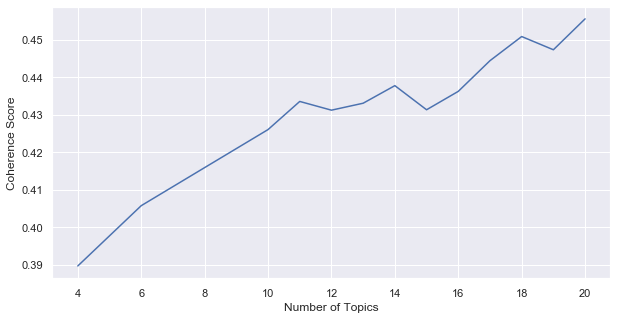

In [41]:
# Show graph
plt.figure(figsize = (10,5))
plt.plot(number_topics, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show()

In [42]:
# Print the coherence scores
for m, cv in zip(number_topics, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 4  has Coherence Value of 0.3896
Num Topics = 6  has Coherence Value of 0.4057
Num Topics = 8  has Coherence Value of 0.4159
Num Topics = 10  has Coherence Value of 0.426
Num Topics = 11  has Coherence Value of 0.4335
Num Topics = 12  has Coherence Value of 0.4312
Num Topics = 13  has Coherence Value of 0.433
Num Topics = 14  has Coherence Value of 0.4377
Num Topics = 15  has Coherence Value of 0.4313
Num Topics = 16  has Coherence Value of 0.4362
Num Topics = 17  has Coherence Value of 0.4444
Num Topics = 18  has Coherence Value of 0.4508
Num Topics = 19  has Coherence Value of 0.4473
Num Topics = 20  has Coherence Value of 0.4556


In [43]:
# Compute perplexity for mallet model. Need further research on this.
#LL_token = [-7.55907, -7.62512, -7.69531, -7.76047, -7.79609, -7.82976, -7.84297, -7.85761, -7.89299, -7.86362, -7.92078,
#          -7.93118, -7.96718, -7.9107] # displayed in the console
#perplexity = [2**(-i) for i in LL_token] 

# Show graph
#plt.figure(figsize = (10,5))
#plt.plot(number_topics, LL_token)
#plt.xlabel("Number of Topics")
#plt.ylabel("Perplexity Score")
#plt.show()    

In [44]:
# Convert Mallet model to gensim LDA model for pyLDAvis plot
def mallet_to_lda(mallet_model):
    #model_gensim = LdaModel(
    #    id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
    #    alpha=mallet_model.alpha, eta=0, iterations=1000,
    #    gamma_threshold=0.001,
    #    dtype=np.float32
    #)
    #model_gensim.sync_state()
    #model_gensim.state.sstats = mallet_model.wordtopics
    
    model_gensim = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(
        mallet_model, iterations=1000)

    return model_gensim

lda_list = []
for mallet_model in model_list:
    lda_list.append(mallet_to_lda(mallet_model))

In [45]:
# Plot topics
# https://www.objectorientedsubject.net/2018/08/experiments-on-topic-modeling-pyldavis/
# Relevance is denoted by λ, the weight assigned to the probability of a term in a topic relative to its lift which is the ratio of a 
# term’s probability within a topic to its margin probability across the corpus. When λ = 1, the terms are ranked by their probabilities 
# within the topic (the ‘regular’ method) while when λ = 0, the terms are ranked only by their lift. The interface allows to adjust the 
# value of λ between 0 and 1. The authors of the paper conducted a study to determine whether there was an optimal value for λ regarding 
# the use of relevance to aid topic interpretation and found that value to be 0.6, as described in section 3 of their paper. In any case, 
# it is very handy to be able to adjust that any time.
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_list[7], corpus, id2word)
vis

/Users/ll/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/ll/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/Users/ll/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
9     -0.302189  0.133759       1        1  8.099275
12    -0.143939 -0.125823       2        1  7.801185
11    -0.213667  0.158791       3        1  7.562610
8     -0.220434 -0.084801       4        1  7.433609
13    -0.119434 -0.103345       5        1  7.304919
7      0.057166 -0.113916       6        1  7.038716
2      0.179078 -0.045421       7        1  7.020983
5      0.096089 -0.022519       8        1  7.019047
6      0.015764 -0.214652       9        1  6.981619
4     -0.021379  0.283181      10        1  6.973104
1      0.063369  0.031139      11        1  6.852430
3      0.127093 -0.203137      12        1  6.813253
0      0.233047  0.074415      13        1  6.753296
10     0.249436  0.232330      14        1  6.345953, topic_info=          Term          Freq         Total Category  logprob  loglift
113      staff  29758.000000  29758.000000  Default  30.0000  30.0000
16       great  31384.000000  31384.000000  Default  29.0000  29.0000
2          bed  21112.000000  21112.000000  Default  28.0000  28.0000
35   breakfast  17869.000000  17869.000000  Default  27.0000  27.0000
50        nice  23988.000000  23988.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
458     lovely    896.691329   2882.624633  Topic14  -5.1445   1.5896
773  attentive    569.422970   1035.050224  Topic14  -5.5986   2.1598
704  concierge    828.360573   3510.320018  Topic14  -5.2238   1.3133
62       visit    660.530645   5733.575092  Topic14  -5.4502   0.5963
433     modern    622.169518   2991.213585  Topic14  -5.5100   1.1871

[1143 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
3848      4  0.996439         ac_unit
172       7  0.172585          access
172       9  0.827427          access
1545     14  0.998910   accommodating
1259      5  0.013220       accomodat
...     ...       ...             ...
1383     11  0.342468            year
3440     13  0.995573           yotel
3779     11  1.001576  young_children
1172      3  1.005997       young_man
474      11  1.001079             zoo

[1720 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 13, 12, 9, 14, 8, 3, 6, 7, 5, 2, 4, 1, 11])

By observing the coherence scores and topic plots given above, I decided to choose 14 as the number of topics, because it has a high coherence score and its topics are also easy to explain.

In [46]:
# Select the best model with 14 topics and print the topics
optimal_model = model_list[7]
model_topics = optimal_model.show_topics(formatted=False)
#pprint(model_topics)
pprint(optimal_model.print_topics(num_words=15))

[(0,
  '0.052*"location" + 0.032*"good" + 0.032*"city" + 0.026*"great" + '
  '0.026*"nyc" + 0.025*"time" + 0.025*"new_york" + 0.024*"view" + '
  '0.020*"times_square" + 0.018*"subway" + 0.018*"floor" + 0.018*"walk" + '
  '0.014*"recommend" + 0.013*"clean" + 0.013*"street"'),
 (1,
  '0.042*"pool" + 0.037*"view" + 0.034*"nice" + 0.030*"great" + 0.027*"area" + '
  '0.026*"family" + 0.024*"place" + 0.024*"property" + 0.022*"weekend" + '
  '0.020*"enjoy" + 0.019*"kid" + 0.016*"beautiful" + 0.015*"time" + '
  '0.013*"love" + 0.013*"day"'),
 (2,
  '0.067*"walk" + 0.035*"street" + 0.033*"block" + 0.029*"restaurant" + '
  '0.026*"airport" + 0.026*"close" + 0.021*"easy" + 0.019*"minute" + '
  '0.019*"area" + 0.018*"shuttle" + 0.018*"place" + 0.016*"stop" + '
  '0.015*"locate" + 0.015*"city" + 0.014*"bus"'),
 (3,
  '0.128*"bed" + 0.085*"nice" + 0.062*"good" + 0.061*"clean" + '
  '0.042*"comfortable" + 0.042*"small" + 0.031*"night" + 0.031*"bathroom" + '
  '0.029*"size" + 0.020*"king" + 0.020*"big

In [48]:
# Define the names of the topics
name_topics={0: 'nyc', 1: 'family friendly', 2: 'transportation', 3: 'bedroom', 4: 'business service', 5:'bar/restaurant', 6: 'parking', 7:'breakfast', 
             8:'noise', 9:'customer service', 10:'staff', 11:'check in/out', 12:'bathroom', 13:'reservation' }

# 4. Finding the dominant topics in each sentence

In [49]:
# Find top_n topics in each document
def find_sentences_topics(ldamodel=lda_model, corpus=corpus):
    # Init output
    sent_topics_df = pd.DataFrame()
    top_n = 14
    # Get main topics in each document
    for i, row in enumerate(ldamodel[corpus]):
        # For each document, sort the topics according to the Perc Contribution
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant/sorted topics, Perc Contributions, and Keywords. Also get scores (Perc Contribution list with original order from topic 0 to topic 14) for each document
        topic_list = []
        prop_topics_list = []
        topic_keywords_list = []
        score_list = np.zeros(len(name_topics)).tolist()
        for j, (topic_num, prop_topic) in enumerate(row):            
            if j < top_n:  # choose top_n dominant topics
                topic_list.append(name_topics[int(topic_num)])
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                topic_keywords_list.append(topic_keywords)
                prop_topics_list.append(round(prop_topic,4))
                score_list[topic_num] = round(prop_topic,4)
            else:
                break
        sent_topics_df = sent_topics_df.append(pd.Series([topic_list, prop_topics_list, topic_keywords_list, score_list]), ignore_index=True)

    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Score_List']
    return(sent_topics_df)

df_topic_sents_keywords = find_sentences_topics(ldamodel=optimal_model, corpus=corpus)

In [50]:
df_topic_sents_keywords.head()

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Score_List
0,"[bar/restaurant, family friendly, nyc, transpo...","[0.156, 0.119, 0.1011, 0.1011, 0.0666, 0.0615,...","[service, restaurant, bar, good, food, lobby, ...","[0.1011, 0.119, 0.1011, 0.0615, 0.0564, 0.156,..."
1,"[bedroom, family friendly, bathroom, noise, st...","[0.1387, 0.1127, 0.1003, 0.0839, 0.0756, 0.067...","[bed, nice, good, clean, comfortable, small, n...","[0.0619, 0.1127, 0.0455, 0.1387, 0.0537, 0.044..."
2,"[staff, bedroom, family friendly, transportati...","[0.1355, 0.0971, 0.089, 0.087, 0.085, 0.0799, ...","[great, staff, friendly, location, helpful, cl...","[0.0759, 0.089, 0.087, 0.0971, 0.0799, 0.0668,..."
3,"[business service, bar/restaurant, breakfast, ...","[0.1562, 0.1375, 0.1013, 0.0701, 0.0663, 0.063...","[make, service, staff, experience, feel, trip,...","[0.0439, 0.0501, 0.0638, 0.0451, 0.1562, 0.137..."
4,"[nyc, staff, bedroom, family friendly, transpo...","[0.0958, 0.0841, 0.0783, 0.0763, 0.0744, 0.070...","[location, good, city, great, nyc, time, new_y...","[0.0958, 0.0763, 0.0744, 0.0783, 0.0685, 0.062..."


In [51]:
# Combine original dataframe with the topics and scores
df_new = pd.concat([df,df_topic_sents_keywords], axis=1)

In [52]:
df_new.head()

,User_ID,Description,Is_Response,hotel_ID,Dominant_Topic,Perc_Contribution,Topic_Keywords,Score_List
0,id10329,Stayed here with husband and sons on the way t...,happy,8,"[bar/restaurant, family friendly, nyc, transpo...","[0.156, 0.119, 0.1011, 0.1011, 0.0666, 0.0615,...","[service, restaurant, bar, good, food, lobby, ...","[0.1011, 0.119, 0.1011, 0.0615, 0.0564, 0.156,..."
1,id10331,We had - rooms. One was very nice and clearly ...,happy,3,"[bedroom, family friendly, bathroom, noise, st...","[0.1387, 0.1127, 0.1003, 0.0839, 0.0756, 0.067...","[bed, nice, good, clean, comfortable, small, n...","[0.0619, 0.1127, 0.0455, 0.1387, 0.0537, 0.044..."
2,id10333,My wife & I stayed in this glorious city a whi...,happy,3,"[staff, bedroom, family friendly, transportati...","[0.1355, 0.0971, 0.089, 0.087, 0.085, 0.0799, ...","[great, staff, friendly, location, helpful, cl...","[0.0759, 0.089, 0.087, 0.0971, 0.0799, 0.0668,..."
3,id10334,My boyfriend and I stayed at the Fairmont on a...,happy,7,"[business service, bar/restaurant, breakfast, ...","[0.1562, 0.1375, 0.1013, 0.0701, 0.0663, 0.063...","[make, service, staff, experience, feel, trip,...","[0.0439, 0.0501, 0.0638, 0.0451, 0.1562, 0.137..."
4,id10336,"Steps off Times Square, nice rooms, stayed - n...",happy,3,"[nyc, staff, bedroom, family friendly, transpo...","[0.0958, 0.0841, 0.0783, 0.0763, 0.0744, 0.070...","[location, good, city, great, nyc, time, new_y...","[0.0958, 0.0763, 0.0744, 0.0783, 0.0685, 0.062..."


In [53]:
# Define score as positive if it is a happy review, otherwise negative.
df_new.Score_List = [[df_new.Score_List[i], (np.array(df_new.Score_List[i])*(-1)).tolist()][df_new.Is_Response[i]=='not happy'] for i in range(len(df_new))]

In [54]:
df_new.head()

,User_ID,Description,Is_Response,hotel_ID,Dominant_Topic,Perc_Contribution,Topic_Keywords,Score_List
0,id10329,Stayed here with husband and sons on the way t...,happy,8,"[bar/restaurant, family friendly, nyc, transpo...","[0.156, 0.119, 0.1011, 0.1011, 0.0666, 0.0615,...","[service, restaurant, bar, good, food, lobby, ...","[0.1011, 0.119, 0.1011, 0.0615, 0.0564, 0.156,..."
1,id10331,We had - rooms. One was very nice and clearly ...,happy,3,"[bedroom, family friendly, bathroom, noise, st...","[0.1387, 0.1127, 0.1003, 0.0839, 0.0756, 0.067...","[bed, nice, good, clean, comfortable, small, n...","[0.0619, 0.1127, 0.0455, 0.1387, 0.0537, 0.044..."
2,id10333,My wife & I stayed in this glorious city a whi...,happy,3,"[staff, bedroom, family friendly, transportati...","[0.1355, 0.0971, 0.089, 0.087, 0.085, 0.0799, ...","[great, staff, friendly, location, helpful, cl...","[0.0759, 0.089, 0.087, 0.0971, 0.0799, 0.0668,..."
3,id10334,My boyfriend and I stayed at the Fairmont on a...,happy,7,"[business service, bar/restaurant, breakfast, ...","[0.1562, 0.1375, 0.1013, 0.0701, 0.0663, 0.063...","[make, service, staff, experience, feel, trip,...","[0.0439, 0.0501, 0.0638, 0.0451, 0.1562, 0.137..."
4,id10336,"Steps off Times Square, nice rooms, stayed - n...",happy,3,"[nyc, staff, bedroom, family friendly, transpo...","[0.0958, 0.0841, 0.0783, 0.0763, 0.0744, 0.070...","[location, good, city, great, nyc, time, new_y...","[0.0958, 0.0763, 0.0744, 0.0783, 0.0685, 0.062..."


In [55]:
# Generate a report dataframe containing scores and top reviews of each topic for each hotel
top_n = 2 # Number of top reviews to show
df_hotel_scores = pd.DataFrame()
hotels = sorted(df_new['hotel_ID'].unique())
for h in hotels:
    df_hotel = df_new[df_new['hotel_ID']==h]
    for t in range(len(name_topics)):
        s = np.array([df_hotel.Score_List.iloc[i][t] for i in range(len(df_hotel))]) # Perc_Contributions for topic t
        hotels_score = sum(s) # Score of a topic for a hotel is defined as the sum of all Perc_Contributions from all customers about this topic for this hotel
        ind = np.argsort(abs(s))[-top_n:][::-1] # Indexes for top n reviews with hightest Perc_Contribution for topic t
        Top_Reviews = df_hotel.iloc[ind]['Description'] # Top n reviews
        wp = optimal_model.show_topic(t)
        topic_keywords = ", ".join([word for word, prop in wp])
        df_hotel_scores = df_hotel_scores.append(pd.Series([int(h), name_topics[t], hotels_score, topic_keywords, Top_Reviews]), ignore_index=True)

df_hotel_scores.columns = ['hotel_ID', 'Topic', 'Score', 'Key_Words', 'Top_Reviews']    

In [56]:
df_hotel_scores

,hotel_ID,Topic,Score,Key_Words,Top_Reviews
0,1.0,nyc,61.9264,"location, good, city, great, nyc, time, new_yo...","34477 Like other reviews i have read, mysel..."
1,1.0,family friendly,48.0492,"pool, view, nice, great, area, family, place, ...",10762 My husband and I suffered a great dea...
2,1.0,transportation,54.6348,"walk, street, block, restaurant, airport, clos...",13233 From our corner king room on the --th...
3,1.0,bedroom,36.6072,"bed, nice, good, clean, comfortable, small, ni...",18857 We stayed at the Palomar in Westwood ...
4,1.0,business service,54.3979,"make, service, staff, experience, feel, trip, ...",4652 My clients are in the entertainment fi...
...,...,...,...,...,...
135,10.0,customer service,-19.4559,"call, desk, front, give, manager, guest, reser...",34043 I would never stay at this hotel agai...
136,10.0,staff,22.2022,"great, staff, friendly, location, helpful, cle...",11030 I just returnd to Ireland after a - n...
137,10.0,check in/out,-3.0396,"check, desk, time, front, back, arrive, day, h...",32742 “If you like bad service this is the ...
138,10.0,bathroom,-7.4660,"bathroom, shower, floor, elevator, water, work...","33005 I've stayed at many, many Kimpton Hot..."


In [57]:
# Use 'hotel_ID' and 'Topic' as indexes
df_hotel_scores = df_hotel_scores.set_index(['hotel_ID', 'Topic']) 
df_hotel_scores

Score  \
hotel_ID Topic                       
1.0      nyc               61.9264   
         family friendly   48.0492   
         transportation    54.6348   
         bedroom           36.6072   
         business service  54.3979   
...                            ...   
10.0     customer service -19.4559   
         staff             22.2022   
         check in/out      -3.0396   
         bathroom          -7.4660   
         reservation       -4.0271   

                                                                   Key_Words  \
hotel_ID Topic                                                                 
1.0      nyc               location, good, city, great, nyc, time, new_yo...   
         family friendly   pool, view, nice, great, area, family, place, ...   
         transportation    walk, street, block, restaurant, airport, clos...   
         bedroom           bed, nice, good, clean, comfortable, small, ni...   
         business service  make, service, staff, experience, feel, trip, ...   
...                                                                      ...   
10.0     customer service  call, desk, front, give, manager, guest, reser...   
         staff             great, staff, friendly, location, helpful, cle...   
         check in/out      check, desk, time, front, back, arrive, day, h...   
         bathroom          bathroom, shower, floor, elevator, water, work...   
         reservation       night, book, price, review, find, place, pay, ...   

                                                                 Top_Reviews  
hotel_ID Topic                                                                
1.0      nyc               34477    Like other reviews i have read, mysel...  
         family friendly   10762    My husband and I suffered a great dea...  
         transportation    13233    From our corner king room on the --th...  
         bedroom           18857    We stayed at the Palomar in Westwood ...  
         business service  4652    My clients are in the entertainment fi...  
...                                                                      ...  
10.0     customer service  34043    I would never stay at this hotel agai...  
         staff             11030    I just returnd to Ireland after a - n...  
         check in/out      32742    “If you like bad service this is the ...  
         bathroom          33005    I've stayed at many, many Kimpton Hot...  
         reservation       30429    My wife and I pored over Trip Advisor...  

[140 rows x 3 columns]

In [58]:
# Scores and top reviews for hotel 1
df_hotel_scores.loc[1]

,Score,Key_Words,Top_Reviews
Topic,,,
nyc,61.9264,"location, good, city, great, nyc, time, new_yo...","34477 Like other reviews i have read, mysel..."
family friendly,48.0492,"pool, view, nice, great, area, family, place, ...",10762 My husband and I suffered a great dea...
transportation,54.6348,"walk, street, block, restaurant, airport, clos...",13233 From our corner king room on the --th...
bedroom,36.6072,"bed, nice, good, clean, comfortable, small, ni...",18857 We stayed at the Palomar in Westwood ...
business service,54.3979,"make, service, staff, experience, feel, trip, ...",4652 My clients are in the entertainment fi...
bar/restaurant,52.8995,"service, restaurant, bar, good, food, lobby, d...",30459 My husband and I stayed at the Hyatt ...
parking,27.4283,"parking, free, car, business, internet, park, ...",23628 I used my Marriott Reward points to s...
breakfast,48.1859,"breakfast, coffee, free, area, include, suite,...",24019 Homewood Suites was a real find! I re...
noise,-35.7244,"night, noise, door, bad, hear, sleep, floor, p...",28170 Though this hotel didn't have cockroa...


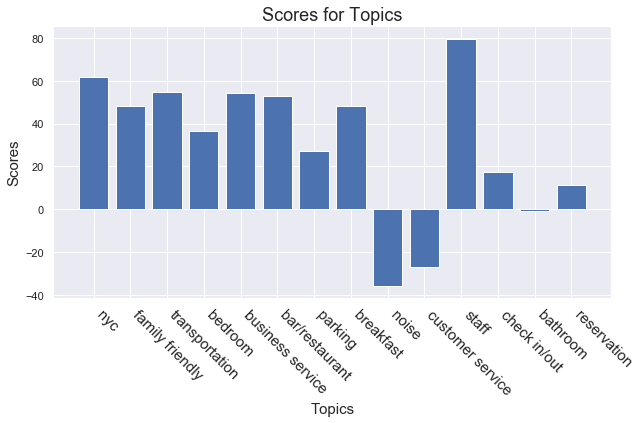

In [59]:
plt.figure(figsize = (10,5))
plt.bar(df_hotel_scores.loc[1].index, df_hotel_scores.loc[1].Score)#, width=1)
plt.xlabel('Topics', fontsize=15)
plt.ylabel('Scores', fontsize=15)
plt.title('Scores for Topics', fontsize=18)
plt.xticks(fontsize=15, rotation =-45, ha='left')
plt.show()

We can see that for hotel 1, its 'noise' and 'customer service' have the lowest scores, while its staff and location in NYC have the highest scores. Details can be found in the following top reviews for these topics.

In [61]:
# Top two reviews about 'bathroom' for hotel 1
for i in range(top_n):
    print(df_hotel_scores.loc[1,'noise']['Top_Reviews'].iloc[i])

Though this hotel didn't have cockroaches it looked like a roach motel! When we first walked in the hotel, I noticed that the plaster was cracked and coming off of the ceiling and walls! Check in is at -:--, we arrived at -:-- and our room was not ready! So of course I needed to use the restroom, the door had no lock and there were holes in the plaster and walls where I could see the lathe every where I looked and it was filthy!!! We finally get our room and take the creaky, creepy two person elevator, it opens up to a dark,dank hallway with dirty, stinky, stained carpet! It's an image I could imagine to be in a Steven King Novel!!! Our room was even worse! The head boards and lamp shades had a thick layer of dust and dirt, the lamp shades also had splattered soda, I'm guessing, on the inside! The bathroom was moldy and dirty with the only outlet for the room next to the shower wall! No towel hooks or anywhere to put your toiletry's. I was afraid to sleep in the bed for fear of bed bug

In [60]:
# Top two reviews about 'customer_service' for hotel 1
for i in range(top_n):
    print(df_hotel_scores.loc[1,'customer service']['Top_Reviews'].iloc[i])

I called the hotel on ------- to make a reservation. A friend of mine found the hotel online and wanted to stay there when we visited San Antonio. The gentleman I spoke with was very polite and answered all of my questions. I was leery about the hotel because of reviews I read on this site. I decided because he was so polite that I would give it a try.
I arrived at the Antonian to check-in on August --, ----. I planned on checking out on August --, ----. During the check-in process (right from the beginning when I asked a simple question) I was treated very rudely by the front Desk Clerk. 
I ignored it at first. I gave him my credit card and signed the electronic pad when he indicated I needed to, continuing the check in process despite the rude treatment. 
When he gave me my room keys he also gave me an invoice. The amount on the invoice was higher than the amount I was quoted when I made the reservation. He said I was being charged more per night because there is two of us and I only

In [62]:
# Top two reviews about 'staff' for hotel 1
for i in range(top_n):
    print(df_hotel_scores.loc[1,'staff']['Top_Reviews'].iloc[i])

This hotel was great! The staff was so friendly and accommodating. The room was small (but from what we heard, every room in NY is small) but extremely clean. For - girls in their late --'s it was perfect location! Great bars, great food and great shopping all within walking distance. I will definitely stay here again.
We spent three days here for the taste of chicago we would definitely return again the room was great the bed are comfortable we was on the -- floor the sky deck was beautiful the lobby was spacious moderm and well appointed this location is walking distance to michigan ave where there is great shopping and resturants love this place would definitely return this is one of the most professional desk,concierge host, doorman and housekeeping staffs kathleen you was the best to joe of security who was a great person and may our stay great thank you


In [63]:
# Top two reviews about 'staff' for hotel 1
for i in range(top_n):
    print(df_hotel_scores.loc[1,'nyc']['Top_Reviews'].iloc[i])

Like other reviews i have read, myself and my partner booked this up through an agent without hearing about the reviews. I was horrified when i read them but we wasn't going to let it put a downer on our holiday. 
When we arrived the Hotel lobby is fantastic. Really modern and very busy with people coming in and out. We were on the -rd floor and our room was very basic but clean. It was cleaned everyday with new towels and sheets and the staff were very friendly. 
Hotel Penn is an excellent location. Macy's round the corner, Times Square -- minute walk away. Madison Square Gardens across the road, what more could you ask for.
I would reccomend this Hotel to anyone and would definatley saty there if i was to visit New York again. After all, how much time do you actually spend in the Hotel when you are in a beautiful city like New York.
We just returned from a wonderful time in NYC and the Hilton Times Square added to our enjoyment. The hotel is located in the heart of Times Square just 

From the above reviews, we can see that for hotel 1, it is close to highway and noisy. Its billing department needs to improve their service. Its staffs did a good job. It is close to many NYC landmarks, and thus its location can be used in the advertisement to attract more customers. Suggestions for other hotels can be obtained similarly.